Feed-forward NN to predict precip. as a function of the input thermodynamics

In [1]:
import os
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import matplotlib
import datetime as dt

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Define neural network

In [4]:
class NeuralNetwork_2D(nn.Module):
    def __init__(self):
        super(NeuralNetwork_2D,self).__init__() ## initialize the super class
        
        self.flatten=nn.Flatten()
        self.layer1=nn.Linear(54,256)
        self.layer2=nn.Linear(256,256)
        self.layer3=nn.Linear(256,256)
        self.layer4=nn.Linear(256,256)
        self.layer5=nn.Linear(256,256)
        self.layer6=nn.Linear(256,1)
        self.dropout = nn.Dropout(0.25)
        
    def forward(self,x):
        x=self.flatten(x)
        x=torch.relu(self.layer1(x))
        x=self.dropout(x)
        x=torch.relu(self.layer2(x))
        x=self.dropout(x)
        x=torch.relu(self.layer3(x))
        x=torch.relu(self.layer4(x))
        x=torch.relu(self.layer5(x))
        x=torch.sigmoid(self.layer6(x))
        
        return x
        
model=NeuralNetwork_2D().to(device)

### Set loss function and optimizer


In [5]:
loss_fn=torch.nn.MSELoss()
optimizer=torch.optim.RMSprop(model.parameters(),lr=0.0001)

### Load trained weights ###

In [7]:
path='./NN_6layers_full_vert_Tq.pth'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

### Test output

Load information to de-standardize variables

In [8]:
fil_norm=np.load('./thermo_norm_info.npz')
list(fil_norm.keys())

['sphum_bar', 'sphum_norm', 'temp_bar', 'temp_norm', 'prc_norm']

In [9]:
fil='./Tq_prc_matched_2016_01_02.npz'
f=np.load(fil,'r')
prc_test=f['prc_ocn']
T_test=f['T_ocn'].T  # have time variable first
q_test=f['q_ocn'].T
f.close()

fil1='./era5_condensed_thermo1_2016_01_02.npz'
f=np.load(fil1,'r')
crh_test=f['crh_ocn']
f.close()



In [10]:
x1=(q_test-fil_norm['sphum_bar'])/fil_norm['sphum_norm']
x2=(T_test-fil_norm['temp_bar'])/fil_norm['temp_norm']
x=np.hstack((x1,x2))

In [11]:
prc_predicted=model(torch.from_numpy(x).float().unsqueeze(1)).detach().numpy()*fil_norm['prc_norm']

/tmp/ipykernel_7656/1050510549.py:19: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(left=0,right=5e1)


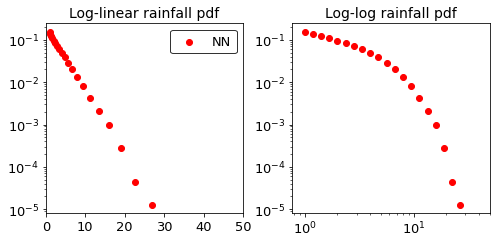

In [35]:
pcp_bins=2**(np.arange(0,8.0,0.25))
pcp_pred_hist=np.histogram(prc_predicted,bins=pcp_bins)

fig,axx=plt.subplots(1,2,figsize=(7,3.5))

ax=axx[0]
ax.scatter(pcp_bins[:-1],pcp_pred_hist[0]/(pcp_pred_hist[0].sum()),c='red',label='NN')
ax.set_yscale('log')
ax.set_xlim(left=0,right=5e1)
ax.tick_params(which='both',labelsize=13)
ax.legend(fontsize=13).get_frame().set_edgecolor('black')
ax.set_title('Log-linear rainfall pdf',fontsize=14)

ax=axx[1]
ax.scatter(pcp_bins[:-1],pcp_pred_hist[0]/(pcp_pred_hist[0].sum()),c='red')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(left=0,right=5e1)

ax.tick_params(which='both',labelsize=13)
ax.set_title('Log-log rainfall pdf',fontsize=14)

plt.tight_layout()




In [39]:
crh_bins=np.arange(0,1.05,.05)

def bin_prc_crh(prc,crh,
                crh_bins,pcp_bins):
    
    crh_index=np.int_((crh-crh_bins[0])/np.diff(crh_bins)[0])
    pcp_crh_joint_pdf=np.zeros((crh_bins.size,pcp_bins.size-1))
    pcp_crh_binned=np.zeros((crh_bins.size))
    for i,j in enumerate(crh_bins):
        indx=np.where(crh_index==i)[0]
        pcp_crh_joint_pdf[i,:]=np.histogram(prc[indx],bins=pcp_bins)[0]
        pcp_crh_binned[i]=prc[indx].mean()
        
    return pcp_crh_binned,pcp_crh_joint_pdf


pcp_crh_binned_pred,pcp_crh_joint_pdf_pred=bin_prc_crh(prc_predicted,
                                                       crh_test,crh_bins,pcp_bins)



/tmp/ipykernel_7656/860423717.py:12: RuntimeWarning: Mean of empty slice.
  pcp_crh_binned[i]=prc[indx].mean()
/home/fiaz/anaconda3/envs/ML/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


/tmp/ipykernel_7656/565245955.py:16: RuntimeWarning: divide by zero encountered in log10
  np.log10(pcp_crh_joint_pdf_pred).T,cmap=plt.get_cmap('YlOrRd'))


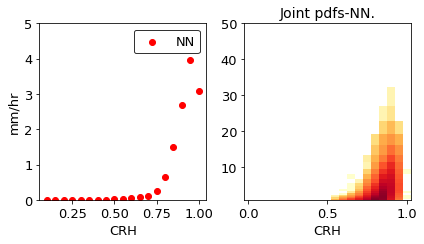

In [42]:
fig,axx=plt.subplots(1,2,figsize=(6,3.5))

ax=axx[0]
ax.scatter(crh_bins,pcp_crh_binned_pred,c='red',label='NN')

ax.set_ylim(bottom=0,top=5)
ax.tick_params(which='both',labelsize=13)

ax.legend(fontsize=13).get_frame().set_edgecolor('black')
ax.set_xlabel('CRH',fontsize=13)
ax.set_ylabel('mm/hr',fontsize=13)


ax=axx[1]
ax.pcolormesh(crh_bins,0.5*(pcp_bins[1:]+pcp_bins[:-1]),
             np.log10(pcp_crh_joint_pdf_pred).T,cmap=plt.get_cmap('YlOrRd'))
ax.tick_params(which='both',labelsize=13)
ax.set_ylim(top=50)
ax.set_xlabel('CRH',fontsize=13)
ax.set_title('Joint pdfs-NN.',fontsize=14)

plt.tight_layout()
